2025-07-05 19:26:07.090683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751714767.119822    5511 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751714767.128249    5511 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751714767.152537    5511 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751714767.152622    5511 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751714767.152627    5511 computation_placer.cc:177] computation placer alr

Kolom tersedia: Index(['Tahun', 'Bulan', 'Total', 'MIGAS', 'NON MIGAS', 'Agriculture',
       'Industry', 'Mining', 'Others'],
      dtype='object')
   Tahun      Bulan      Total     MIGAS  NON MIGAS  Agriculture   Industry  \
0   2016   Desember  13,832.36  1,250.16  12,582.19       357.40  10,092.79   
1   2016   November  13,502.92  1,103.03  12,399.89       359.68  10,097.19   
2   2016    Oktober  12,743.74  1,055.87  11,687.87       380.66   9,613.75   
3   2016  September  12,579.75  1,061.48  11,518.27       345.41   9,444.10   
4   2016    Agustus  12,753.92  1,138.62  11,615.30       389.82   9,473.58   

     Mining  Others  
0  2,083.14   48.86  
1  1,886.60   56.43  
2  1,640.39   53.08  
3  1,687.62   41.15  
4  1,705.39   46.51  


/home/misba/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-05 19:26:09.724800: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


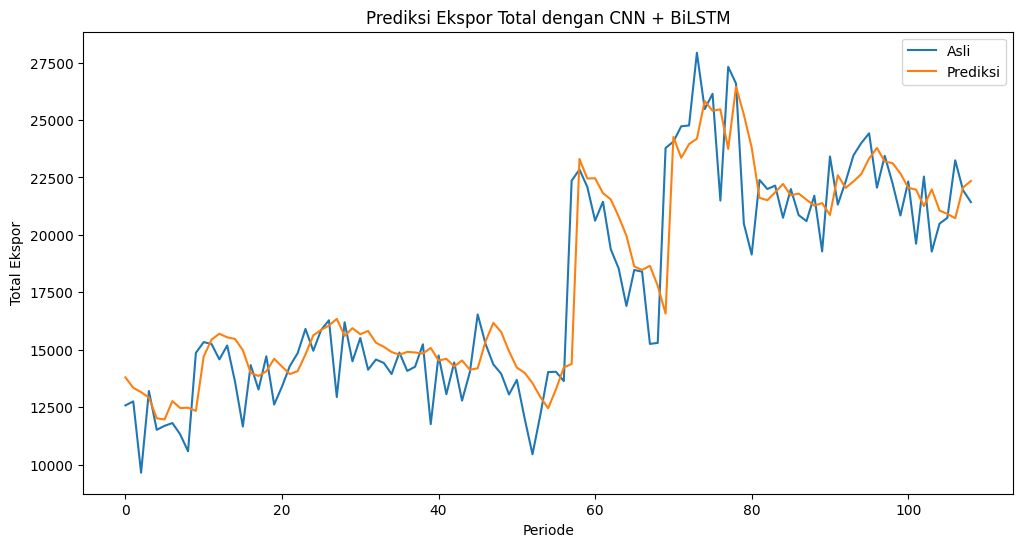

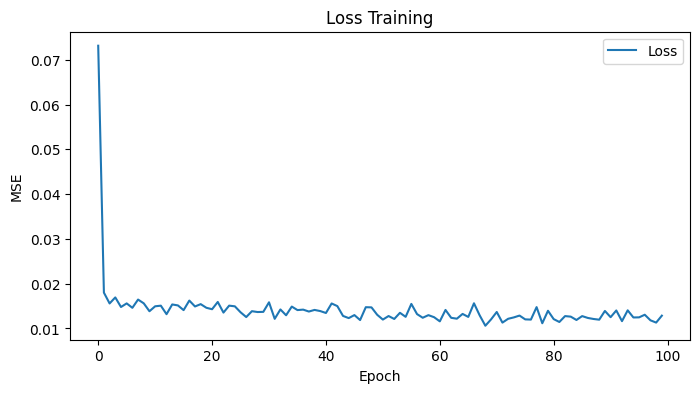

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout

# ==========================================
# Upload file (untuk Colab atau Notebook)
# ==========================================
try:
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
except ImportError:
    filename = 'Ekspor Indonesia.xlsx'  # ganti dengan nama file lokal

# ==========================================
# Load data dari Excel
# ==========================================
df = pd.read_excel(filename)
print("Kolom tersedia:", df.columns)
print(df.head())

# Misalnya pakai kolom 'Total'
# Hapus koma jika pakai notasi ribuan dengan koma, lalu ubah ke float
df['Total'] = df['Total'].astype(str).str.replace(',','').astype(float)

# ==========================================
# Normalisasi
# ==========================================
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Total']])

# ==========================================
# Buat dataset time series
# ==========================================
def create_dataset(dataset, time_steps=3):
    X, y = [], []
    for i in range(len(dataset)-time_steps):
        X.append(dataset[i:(i+time_steps), 0])
        y.append(dataset[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X, y = create_dataset(data_scaled, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# ==========================================
# Buat model CNN + BiLSTM
# ==========================================
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps,1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# ==========================================
# Training
# ==========================================
history = model.fit(X, y, epochs=100, batch_size=4, verbose=0)

# ==========================================
# Prediksi
# ==========================================
predicted = model.predict(X)
predicted_inverse = scaler.inverse_transform(predicted)
y_inverse = scaler.inverse_transform(y.reshape(-1,1))

# ==========================================
# Visualisasi hasil prediksi vs data asli
# ==========================================
plt.figure(figsize=(12,6))
plt.plot(y_inverse, label='Asli')
plt.plot(predicted_inverse, label='Prediksi')
plt.legend()
plt.title('Prediksi Ekspor Total dengan CNN + BiLSTM')
plt.xlabel('Periode')
plt.ylabel('Total Ekspor')
plt.show()

# ==========================================
# Visualisasi loss
# ==========================================
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.title('Loss Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

Kolom tersedia: Index(['Tahun', 'Bulan', 'Total', 'MIGAS', 'NON MIGAS', 'Agriculture',
       'Industry', 'Mining', 'Others'],
      dtype='object')
   Tahun      Bulan      Total     MIGAS  NON MIGAS  Agriculture   Industry  \
0   2016   Desember  13,832.36  1,250.16  12,582.19       357.40  10,092.79   
1   2016   November  13,502.92  1,103.03  12,399.89       359.68  10,097.19   
2   2016    Oktober  12,743.74  1,055.87  11,687.87       380.66   9,613.75   
3   2016  September  12,579.75  1,061.48  11,518.27       345.41   9,444.10   
4   2016    Agustus  12,753.92  1,138.62  11,615.30       389.82   9,473.58   

     Mining  Others  
0  2,083.14   48.86  
1  1,886.60   56.43  
2  1,640.39   53.08  
3  1,687.62   41.15  
4  1,705.39   46.51  


/home/misba/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Nilai Mean Squared Error (MSE): 3616050.34


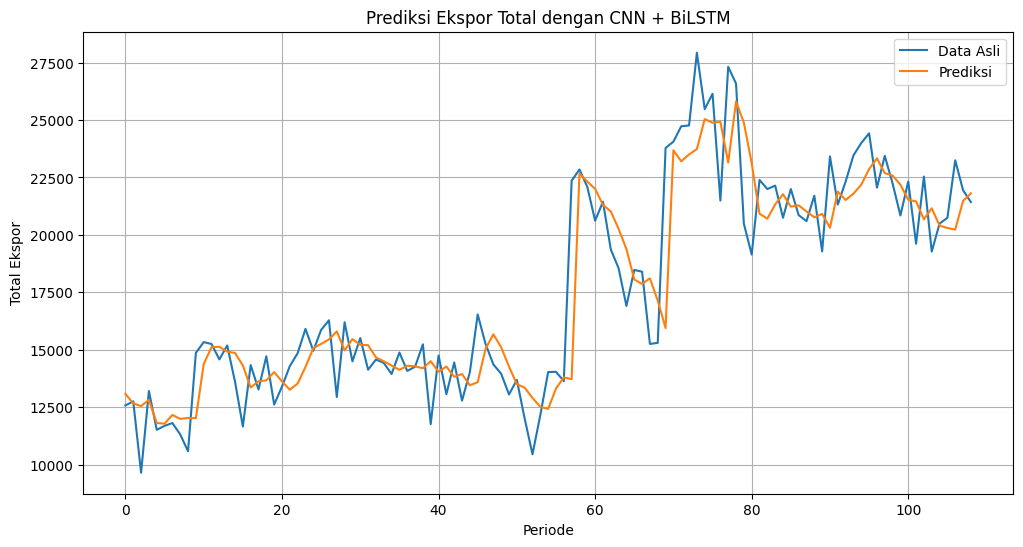

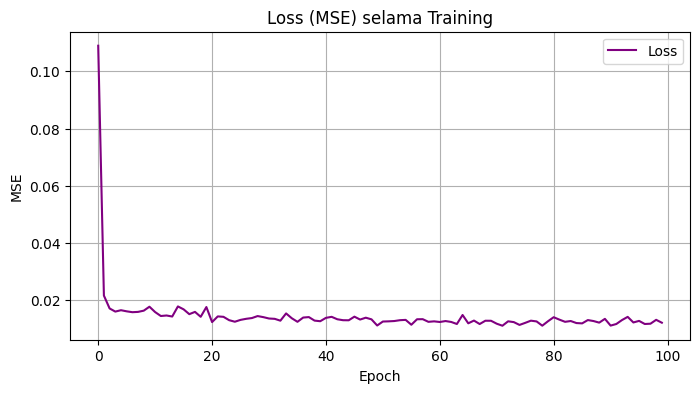

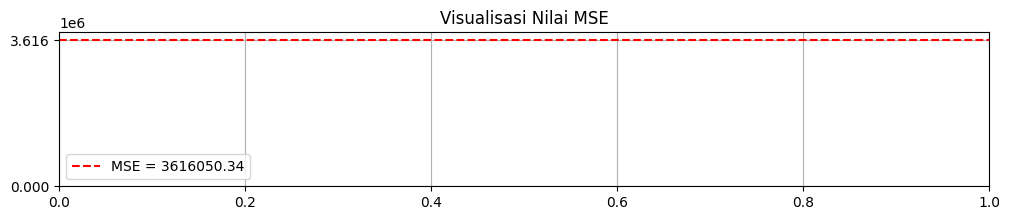

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout

# =================================================
# Upload file (untuk Colab / Notebook) atau lokal
# =================================================
try:
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
except ImportError:
    filename = 'Ekspor Indonesia.xlsx'  # ganti dengan file lokal

# =================================================
# Load data dari Excel
# =================================================
df = pd.read_excel(filename)
print("Kolom tersedia:", df.columns)
print(df.head())

# Convert kolom 'Total'
df['Total'] = df['Total'].astype(str).str.replace(',','').astype(float)

# =================================================
# Normalisasi
# =================================================
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Total']])

# =================================================
# Dataset time series
# =================================================
def create_dataset(dataset, time_steps=3):
    X, y = [], []
    for i in range(len(dataset)-time_steps):
        X.append(dataset[i:(i+time_steps), 0])
        y.append(dataset[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X, y = create_dataset(data_scaled, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# =================================================
# Model CNN + BiLSTM
# =================================================
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps,1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# =================================================
# Training
# =================================================
history = model.fit(X, y, epochs=100, batch_size=4, verbose=0)

# =================================================
# Prediksi
# =================================================
predicted = model.predict(X)
predicted_inverse = scaler.inverse_transform(predicted)
y_inverse = scaler.inverse_transform(y.reshape(-1,1))

# =================================================
# Hitung MSE
# =================================================
mse = mean_squared_error(y_inverse, predicted_inverse)
print(f"Nilai Mean Squared Error (MSE): {mse:.2f}")

# =================================================
# Visualisasi hasil prediksi vs data asli
# =================================================
plt.figure(figsize=(12,6))
plt.plot(y_inverse, label='Data Asli')
plt.plot(predicted_inverse, label='Prediksi')
plt.title('Prediksi Ekspor Total dengan CNN + BiLSTM')
plt.xlabel('Periode')
plt.ylabel('Total Ekspor')
plt.legend()
plt.grid(True)
plt.show()

# =================================================
# Visualisasi loss selama training
# =================================================
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], color='purple', label='Loss')
plt.title('Loss (MSE) selama Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

# =================================================
# Visualisasi nilai MSE dalam bentuk garis horizontal
# =================================================
plt.figure(figsize=(12,2))
plt.axhline(y=mse, color='red', linestyle='--', label=f'MSE = {mse:.2f}')
plt.title('Visualisasi Nilai MSE')
plt.yticks([0, mse])
plt.legend()
plt.grid(True)
plt.show()


In [4]:
pip install numpy pandas matplotlib scikit-learn tensorflow openpyxl


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Kolom tersedia: Index(['Tahun', 'Bulan', 'Total', 'MIGAS', 'NON MIGAS', 'Agriculture',
       'Industry', 'Mining', 'Others'],
      dtype='object')
   Tahun      Bulan      Total     MIGAS  NON MIGAS  Agriculture   Industry  \
0   2016   Desember  13,832.36  1,250.16  12,582.19       357.40  10,092.79   
1   2016   November  13,502.92  1,103.03  12,399.89       359.68  10,097.19   
2   2016    Oktober  12,743.74  1,055.87  11,687.87       380.66   9,613.75   
3   2016  September  12,579.75  1,061.48  11,518.27       345.41   9,444.10   
4   2016    Agustus  12,753.92  1,138.62  11,615.30       389.82   9,473.58   

     Mining  Others  
0  2,083.14   48.86  
1  1,886.60   56.43  
2  1,640.39   53.08  
3  1,687.62   41.15  
4  1,705.39   46.51  


/home/misba/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7dcb2d6e8040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
MSE untuk MIGAS: 17373.44
MSE untuk NON MIGAS: 1291399.36
MSE untuk Agriculture: 1740.52
MSE untuk Industry: 781941.10
MSE untuk Mining: 196758.32
MSE untuk Others: 28.41


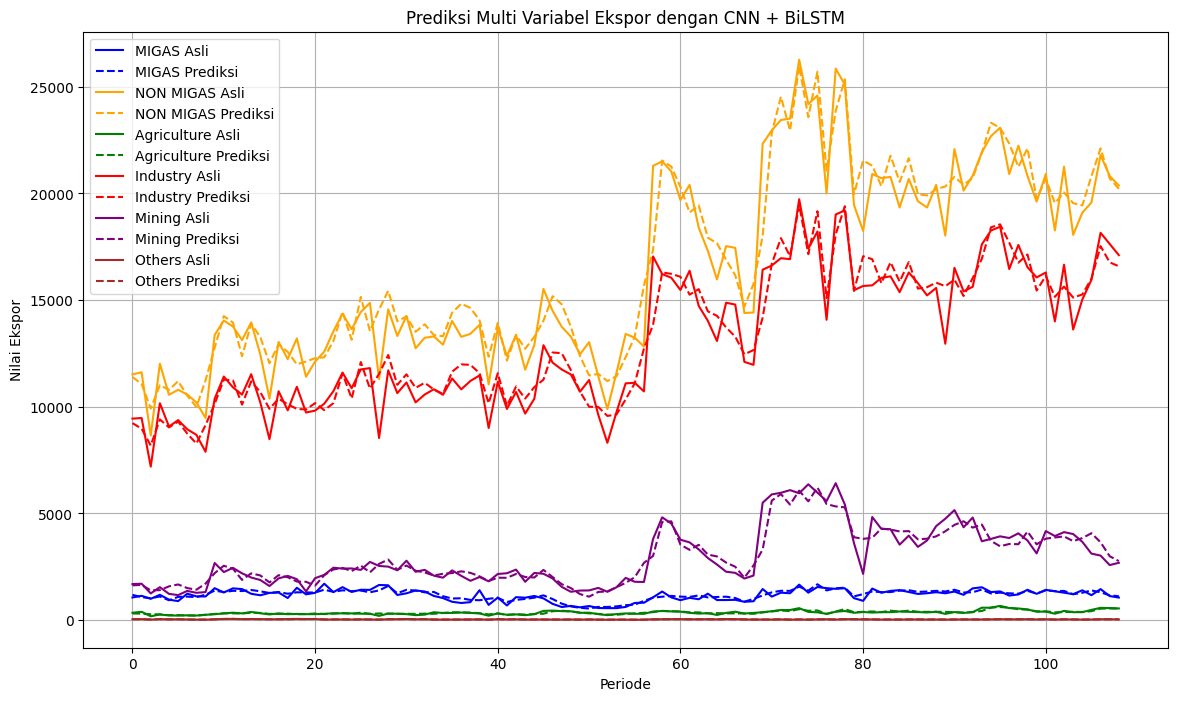

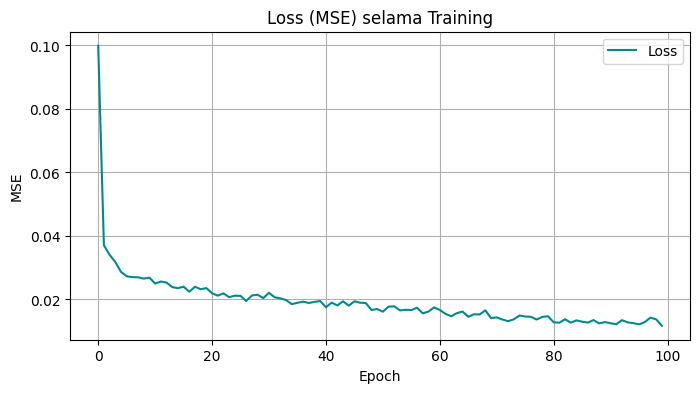

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout

# ===========================================
# Upload file (untuk Colab atau Jupyter)
# ===========================================
try:
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
except ImportError:
    filename = 'Ekspor Indonesia.xlsx'  # ganti dengan file lokal

# ===========================================
# Load data dari Excel
# ===========================================
df = pd.read_excel(filename)
print("Kolom tersedia:", df.columns)
print(df.head())

# ===========================================
# Persiapan data
# ===========================================
# Bersihkan format angka (hapus koma)
for col in ['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']:
    df[col] = df[col].astype(str).str.replace(',','').astype(float)

# ===========================================
# Normalisasi
# ===========================================
scalers = {}
scaled_data = []
for col in ['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']:
    scaler = MinMaxScaler()
    scaled_col = scaler.fit_transform(df[[col]])
    scaled_data.append(scaled_col)
    scalers[col] = scaler

# Gabungkan jadi multi-array
data_scaled = np.hstack(scaled_data)

# ===========================================
# Dataset time series multi-output
# ===========================================
def create_multivariate_dataset(dataset, time_steps=3):
    X, y = [], []
    for i in range(len(dataset)-time_steps):
        X.append(dataset[i:(i+time_steps), :])
        y.append(dataset[i+time_steps, :])
    return np.array(X), np.array(y)

time_steps = 3
X, y = create_multivariate_dataset(data_scaled, time_steps)

# ===========================================
# Model CNN + BiLSTM multi-output
# ===========================================
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, X.shape[2])))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(6))  # 6 output: MIGAS, NON MIGAS, etc
model.compile(optimizer='adam', loss='mse')

# ===========================================
# Training
# ===========================================
history = model.fit(X, y, epochs=100, batch_size=4, verbose=0)

# ===========================================
# Prediksi
# ===========================================
predicted = model.predict(X)

# Kembalikan ke skala asli
predicted_inverse = np.zeros_like(predicted)
y_inverse = np.zeros_like(y)

for i, col in enumerate(['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']):
    predicted_inverse[:, i] = scalers[col].inverse_transform(predicted[:, i].reshape(-1,1)).ravel()
    y_inverse[:, i] = scalers[col].inverse_transform(y[:, i].reshape(-1,1)).ravel()

# ===========================================
# Hitung & tampilkan MSE masing-masing variabel
# ===========================================
for i, col in enumerate(['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']):
    mse = mean_squared_error(y_inverse[:,i], predicted_inverse[:,i])
    print(f"MSE untuk {col}: {mse:.2f}")

# ===========================================
# Visualisasi hasil prediksi vs data asli
# ===========================================
plt.figure(figsize=(14,8))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
for i, col in enumerate(['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']):
    plt.plot(y_inverse[:, i], label=f'{col} Asli', color=colors[i], linestyle='-')
    plt.plot(predicted_inverse[:, i], label=f'{col} Prediksi', color=colors[i], linestyle='--')
plt.title('Prediksi Multi Variabel Ekspor dengan CNN + BiLSTM')
plt.xlabel('Periode')
plt.ylabel('Nilai Ekspor')
plt.legend()
plt.grid(True)
plt.show()

# ===========================================
# Visualisasi loss selama training
# ===========================================
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], color='darkcyan', label='Loss')
plt.title('Loss (MSE) selama Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import pandas as pd

# ===========================================
# Buat DataFrame perbandingan prediksi vs data asli
# ===========================================
n_rows = 10  # berapa baris pertama yg ingin ditampilkan

df_compare = pd.DataFrame()
variabels = ['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']

for i, col in enumerate(variabels):
    df_compare[f'{col}_Asli'] = y_inverse[:n_rows, i]
    df_compare[f'{col}_Pred'] = predicted_inverse[:n_rows, i]

# ===========================================
# Tampilkan tabel
# ===========================================
print("\nPerbandingan Data Asli vs Prediksi (10 data pertama):")
print(df_compare.round(2))



Perbandingan Data Asli vs Prediksi (10 data pertama):
   MIGAS_Asli   MIGAS_Pred  NON MIGAS_Asli  NON MIGAS_Pred  Agriculture_Asli  \
0     1061.48  1183.099976        11518.27    11395.889648            345.41   
1     1138.62  1077.709961        11615.30    11066.940430            389.82   
2      998.64  1025.310059         8650.86     9914.830078            180.84   
3     1187.37  1107.430054        12018.75    11011.190430            262.62   
4      957.96   930.659973        10559.45    10792.830078            220.47   
5      891.74  1089.359985        10798.01    11200.269531            213.08   
6     1239.31  1100.790039        10572.81    10521.200195            224.51   
7     1113.29  1079.410034        10203.45     9987.700195            214.70   
8     1108.03  1189.650024         9473.86    11236.429688            249.40   
9     1496.46  1381.800049        13368.09    12764.879883            275.36   

   Agriculture_Pred  Industry_Asli  Industry_Pred  Mining_Asli  

In [7]:
print("\nManual MSE & RMSE masing-masing variabel:")
for i, col in enumerate(variabels):
    diff_squared = (y_inverse[:, i] - predicted_inverse[:, i]) ** 2
    mse_i = np.mean(diff_squared)
    rmse_i = np.sqrt(mse_i)
    print(f"{col}: MSE = {mse_i:.2f}, RMSE = {rmse_i:.2f}")



Manual MSE & RMSE masing-masing variabel:
MIGAS: MSE = 17373.44, RMSE = 131.81
NON MIGAS: MSE = 1291399.36, RMSE = 1136.40
Agriculture: MSE = 1740.52, RMSE = 41.72
Industry: MSE = 781941.10, RMSE = 884.27
Mining: MSE = 196758.32, RMSE = 443.57
Others: MSE = 28.41, RMSE = 5.33


In [8]:
# hitung selisih persentase semua data
mape_matrix = np.abs((y_inverse - predicted_inverse) / y_inverse) * 100
# rata-rata keseluruhan
mape_total = np.mean(mape_matrix)

print(f"Manual MAPE keseluruhan (semua variabel & semua data) = {mape_total:.2f}%")
print("\nManual MAPE masing-masing variabel:")
for i, col in enumerate(variabels):
    mape_i = np.mean(np.abs((y_inverse[:, i] - predicted_inverse[:, i]) / y_inverse[:, i])) * 100
    print(f"{col}: MAPE = {mape_i:.2f}%")



Manual MAPE keseluruhan (semua variabel & semua data) = 8.96%

Manual MAPE masing-masing variabel:
MIGAS: MAPE = 9.61%
NON MIGAS: MAPE = 5.21%
Agriculture: MAPE = 8.92%
Industry: MAPE = 5.27%
Mining: MAPE = 11.13%
Others: MAPE = 13.64%


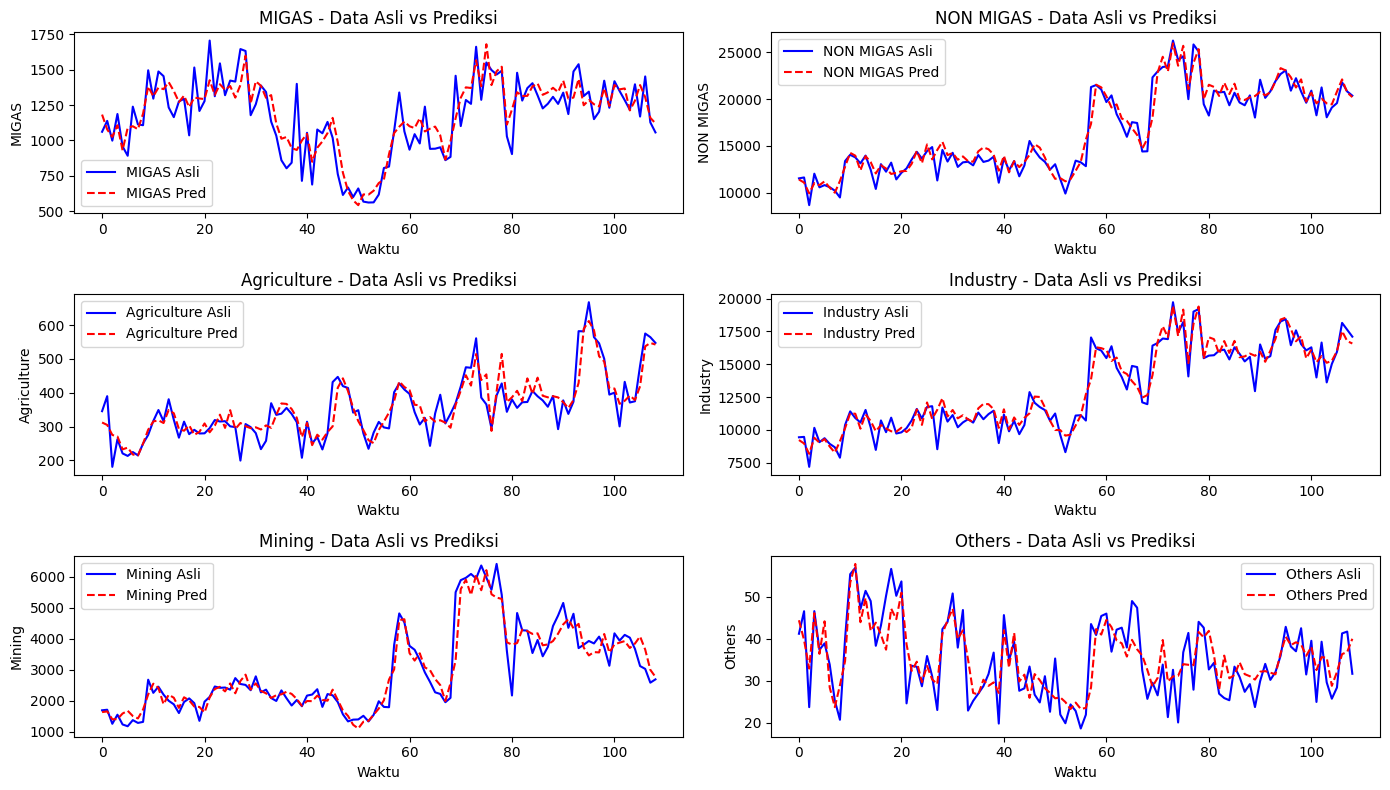

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))

for i, col in enumerate(variabels):
    plt.subplot(3, 2, i+1)
    plt.plot(y_inverse[:, i], label=f"{col} Asli", color='blue')
    plt.plot(predicted_inverse[:, i], label=f"{col} Pred", color='red', linestyle='--')
    plt.title(f"{col} - Data Asli vs Prediksi")
    plt.xlabel("Waktu")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [12]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(y_true, y_pred, model_name):
    print(f"\nEvaluasi {model_name}:")
    results = []
    for i, col in enumerate(['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])
        results.append([col, mse, rmse, mape])
        print(f"{col} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    return pd.DataFrame(results, columns=['Variabel','MSE','RMSE','MAPE'])


In [13]:
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(50), input_shape=(X.shape[1], X.shape[2])))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(6))
model_bilstm.compile(optimizer='adam', loss='mse')
model_bilstm.fit(X, y, epochs=50, verbose=0)

features = ['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']
X_raw = df[features].values[:-1]  # input features
y_raw = df[features].values[1:]   # target shifted 1 step ke depan
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

X = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y = y_scaled





/home/misba/.local/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model_cnn_bilstm = Sequential()
model_cnn_bilstm.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model_cnn_bilstm.add(Bidirectional(LSTM(50)))
model_cnn_bilstm.add(Dropout(0.2))
model_cnn_bilstm.add(Dense(6))
model_cnn_bilstm.compile(optimizer='adam', loss='mse')
model_cnn_bilstm.fit(X, y, epochs=50, verbose=0)


/home/misba/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


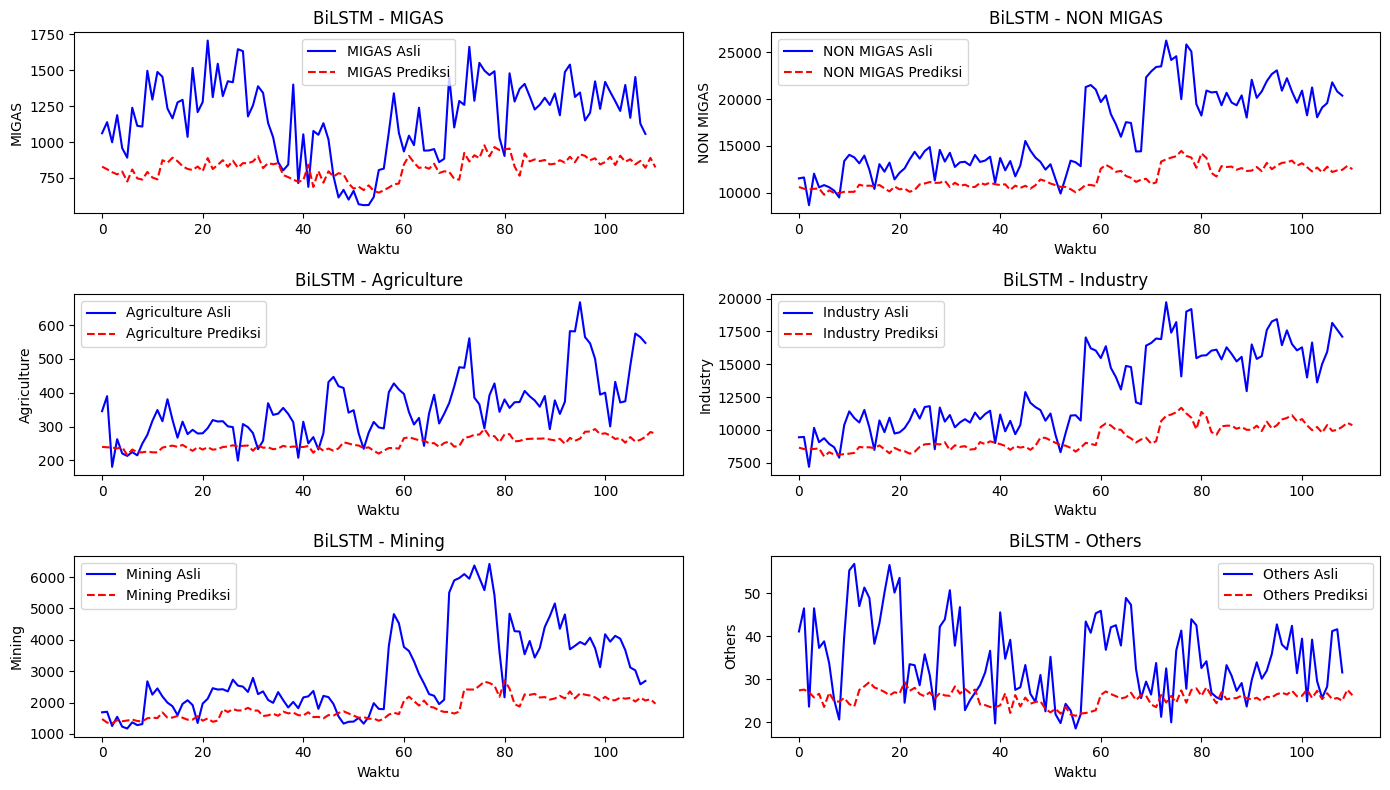

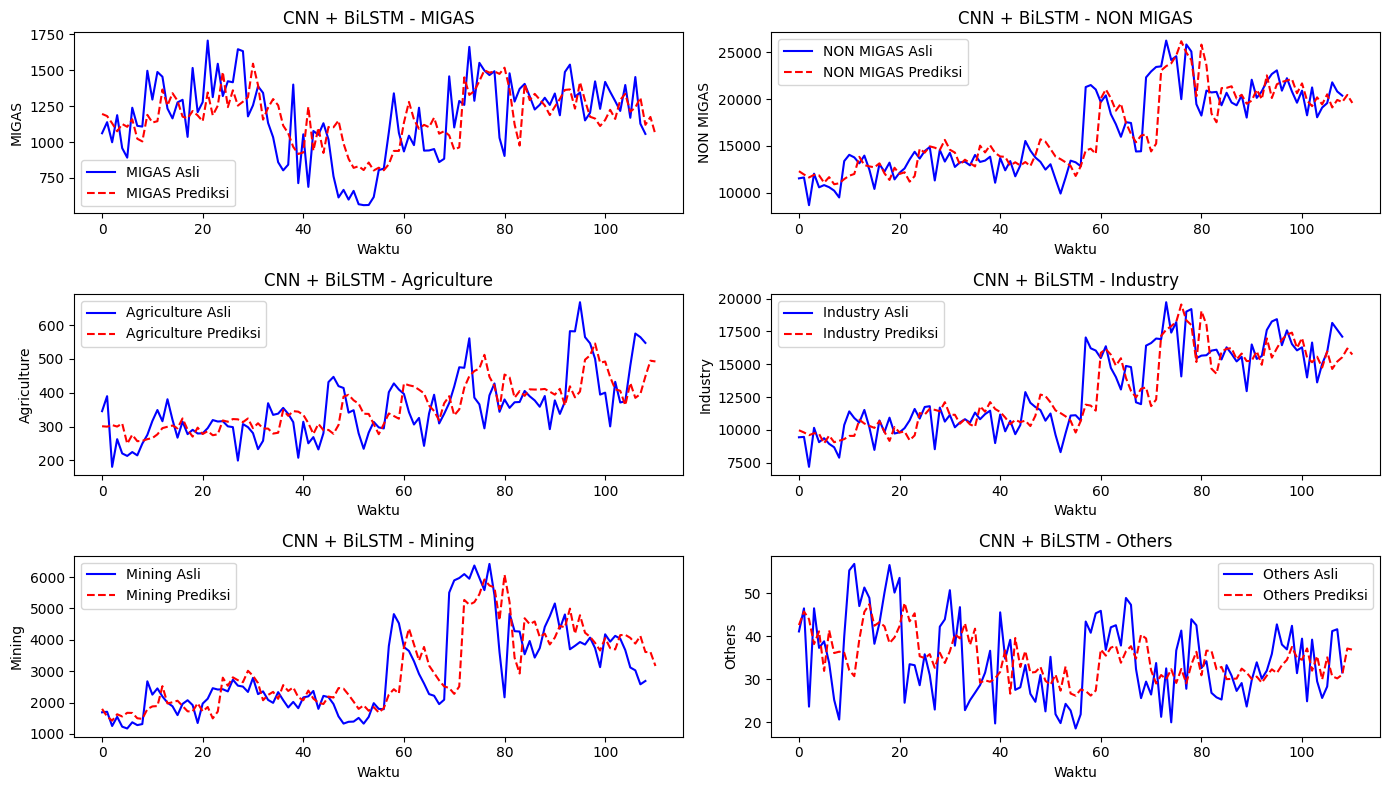

In [15]:

def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(14,8))
    for i, col in enumerate(['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']):
        plt.subplot(3, 2, i+1)
        plt.plot(y_true[:, i], label=f"{col} Asli", color='blue')
        plt.plot(y_pred[:, i], label=f"{col} Prediksi", color='red', linestyle='--')
        plt.title(f"{model_name} - {col}")
        plt.xlabel("Waktu")
        plt.ylabel(col)
        plt.legend()
    plt.tight_layout()
    plt.show()

pred_bilstm = model_bilstm.predict(X)
pred_bilstm_inv = scaler_y.inverse_transform(pred_bilstm)

pred_cnn_bilstm = model_cnn_bilstm.predict(X)
pred_cnn_bilstm_inv = scaler_y.inverse_transform(pred_cnn_bilstm)


plot_predictions(y_inverse, pred_bilstm_inv, "BiLSTM")
plot_predictions(y_inverse, pred_cnn_bilstm_inv, "CNN + BiLSTM")






=== Tabel Evaluasi BiLSTM vs CNN+BiLSTM ===
      Variabel           MSE         RMSE       MAPE       Model
0        MIGAS  1.751394e+05   418.496541  28.565088      BiLSTM
1    NON MIGAS  3.526613e+07  5938.529607  26.679098      BiLSTM
2  Agriculture  1.736175e+04   131.763985  27.182530      BiLSTM
3     Industry  1.901200e+07  4360.275432  25.744238      BiLSTM
4       Mining  2.431882e+06  1559.449340  32.096620      BiLSTM
5       Others  1.603502e+02    12.662945  25.421769      BiLSTM
0        MIGAS  3.809457e+04   195.178305  14.632702  CNN+BiLSTM
1    NON MIGAS  3.330240e+06  1824.894446   8.170191  CNN+BiLSTM
2  Agriculture  3.488395e+03    59.062634  13.155251  CNN+BiLSTM
3     Industry  2.010863e+06  1418.049137   8.011569  CNN+BiLSTM
4       Mining  4.031752e+05   634.960769  16.829142  CNN+BiLSTM
5       Others  6.397096e+01     7.998185  20.518785  CNN+BiLSTM


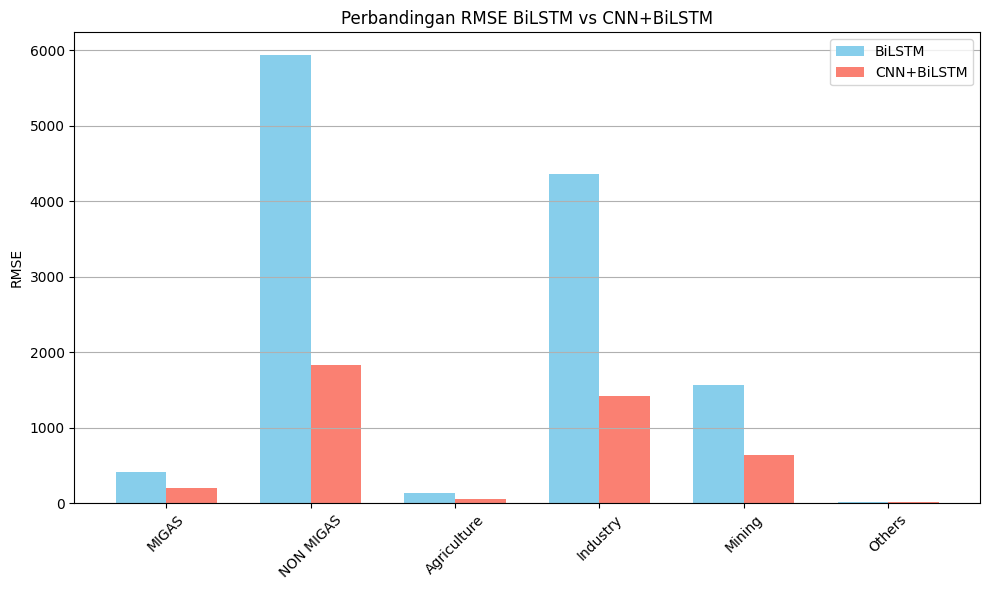

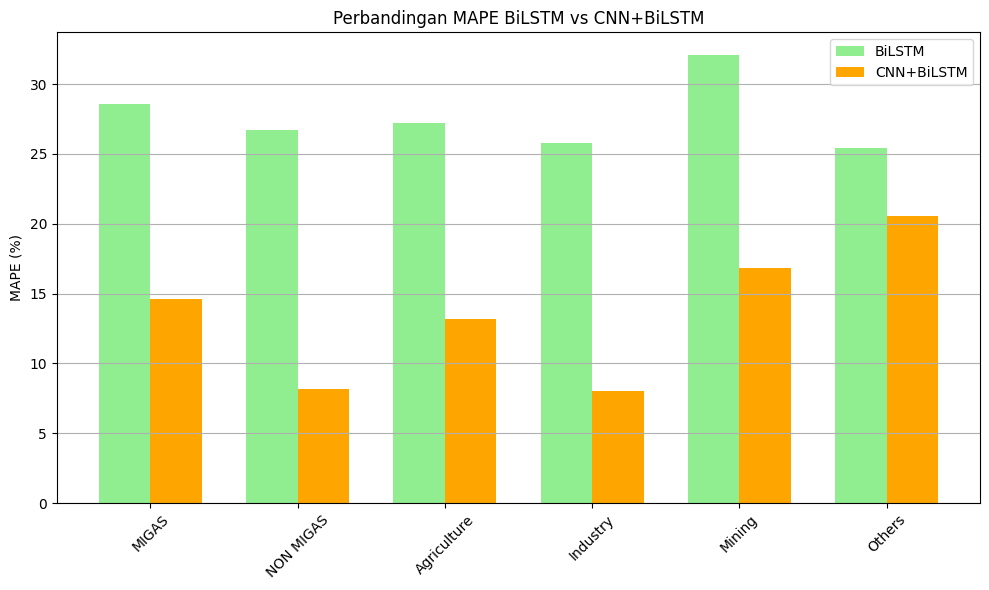

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

variabels = ['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']

def evaluate_model(y_true, y_pred, model_name):
    results = []
    for i, col in enumerate(variabels):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i]) * 100
        results.append([col, mse, rmse, mape])
    df_eval = pd.DataFrame(results, columns=['Variabel', 'MSE', 'RMSE', 'MAPE'])
    df_eval['Model'] = model_name
    return df_eval

# -----------------------------------
# Pastikan panjang sama
# Kita ambil dari belakang agar prediksi sesuai window
min_len = min(y_inverse.shape[0], pred_bilstm_inv.shape[0], pred_cnn_bilstm_inv.shape[0])
y_inverse_cut = y_inverse[-min_len:]
pred_bilstm_cut = pred_bilstm_inv[-min_len:]
pred_cnn_bilstm_cut = pred_cnn_bilstm_inv[-min_len:]

# -----------------------------------
# Evaluasi
df_eval_bilstm = evaluate_model(y_inverse_cut, pred_bilstm_cut, "BiLSTM")
df_eval_cnn_bilstm = evaluate_model(y_inverse_cut, pred_cnn_bilstm_cut, "CNN+BiLSTM")

# Gabung tabel
df_eval_all = pd.concat([df_eval_bilstm, df_eval_cnn_bilstm])

# Tampilkan tabel
print("\n=== Tabel Evaluasi BiLSTM vs CNN+BiLSTM ===")
print(df_eval_all)

# -----------------------------------
# Bar plot RMSE
labels = df_eval_bilstm['Variabel']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, df_eval_bilstm['RMSE'], width, label='BiLSTM', color='skyblue')
rects2 = ax.bar(x + width/2, df_eval_cnn_bilstm['RMSE'], width, label='CNN+BiLSTM', color='salmon')
ax.set_ylabel('RMSE')
ax.set_title('Perbandingan RMSE BiLSTM vs CNN+BiLSTM')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -----------------------------------
# Bar plot MAPE
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, df_eval_bilstm['MAPE'], width, label='BiLSTM', color='lightgreen')
rects2 = ax.bar(x + width/2, df_eval_cnn_bilstm['MAPE'], width, label='CNN+BiLSTM', color='orange')
ax.set_ylabel('MAPE (%)')
ax.set_title('Perbandingan MAPE BiLSTM vs CNN+BiLSTM')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()



=== Evaluasi BiLSTM ===
MIGAS: MSE = 175139.36, RMSE = 418.50, MAPE = 28.57%
NON MIGAS: MSE = 35266133.90, RMSE = 5938.53, MAPE = 26.68%
Agriculture: MSE = 17361.75, RMSE = 131.76, MAPE = 27.18%
Industry: MSE = 19012001.84, RMSE = 4360.28, MAPE = 25.74%
Mining: MSE = 2431882.25, RMSE = 1559.45, MAPE = 32.10%
Others: MSE = 160.35, RMSE = 12.66, MAPE = 25.42%

=== Evaluasi CNN+BiLSTM ===
MIGAS: MSE = 38094.57, RMSE = 195.18, MAPE = 14.63%
NON MIGAS: MSE = 3330239.74, RMSE = 1824.89, MAPE = 8.17%
Agriculture: MSE = 3488.39, RMSE = 59.06, MAPE = 13.16%
Industry: MSE = 2010863.35, RMSE = 1418.05, MAPE = 8.01%
Mining: MSE = 403175.18, RMSE = 634.96, MAPE = 16.83%
Others: MSE = 63.97, RMSE = 8.00, MAPE = 20.52%

=== Tabel DataFrame Evaluasi ===
      Variabel           MSE         RMSE       MAPE       Model
0        MIGAS  1.751394e+05   418.496541  28.565088      BiLSTM
1    NON MIGAS  3.526613e+07  5938.529607  26.679098      BiLSTM
2  Agriculture  1.736175e+04   131.763985  27.182530    

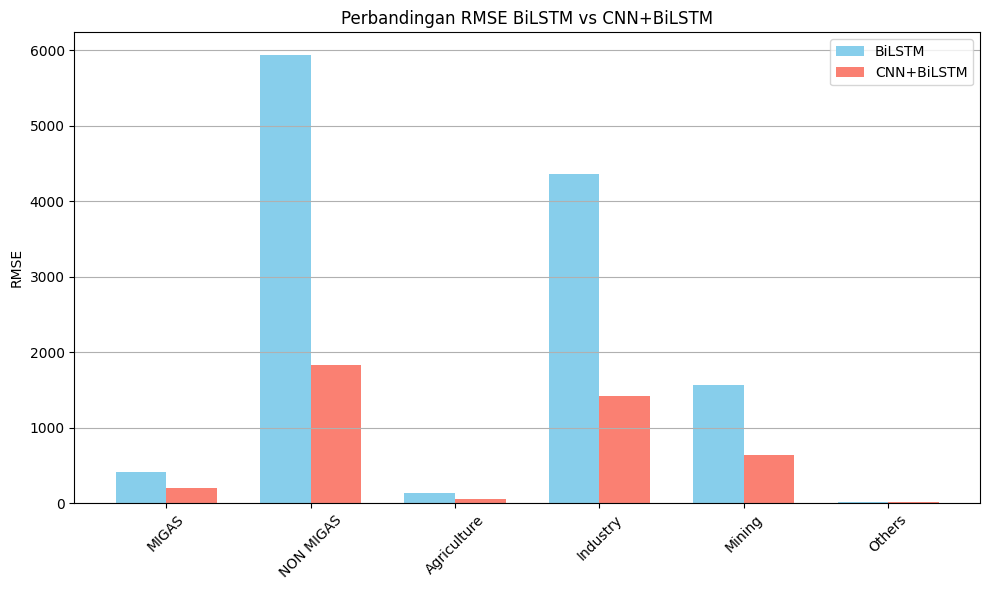

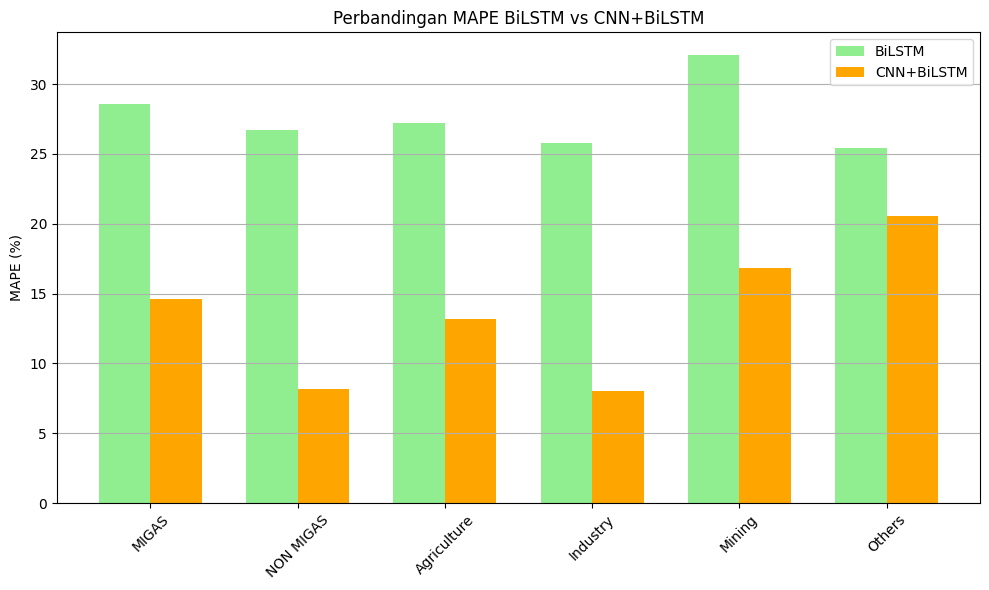

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

variabels = ['MIGAS', 'NON MIGAS', 'Agriculture', 'Industry', 'Mining', 'Others']

def evaluate_model(y_true, y_pred, model_name):
    results = []
    print(f"\n=== Evaluasi {model_name} ===")
    for i, col in enumerate(variabels):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i]) * 100
        results.append([col, mse, rmse, mape])
        print(f"{col}: MSE = {mse:.2f}, RMSE = {rmse:.2f}, MAPE = {mape:.2f}%")
    df_eval = pd.DataFrame(results, columns=['Variabel', 'MSE', 'RMSE', 'MAPE'])
    df_eval['Model'] = model_name
    return df_eval

# -----------------------------------
# Pastikan panjang sama
min_len = min(y_inverse.shape[0], pred_bilstm_inv.shape[0], pred_cnn_bilstm_inv.shape[0])
y_inverse_cut = y_inverse[-min_len:]
pred_bilstm_cut = pred_bilstm_inv[-min_len:]
pred_cnn_bilstm_cut = pred_cnn_bilstm_inv[-min_len:]

# -----------------------------------
# Evaluasi & print
df_eval_bilstm = evaluate_model(y_inverse_cut, pred_bilstm_cut, "BiLSTM")
df_eval_cnn_bilstm = evaluate_model(y_inverse_cut, pred_cnn_bilstm_cut, "CNN+BiLSTM")

# Gabungkan tabel
df_eval_all = pd.concat([df_eval_bilstm, df_eval_cnn_bilstm])

print("\n=== Tabel DataFrame Evaluasi ===")
print(df_eval_all)

# -----------------------------------
# Bar plot RMSE
labels = df_eval_bilstm['Variabel']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, df_eval_bilstm['RMSE'], width, label='BiLSTM', color='skyblue')
ax.bar(x + width/2, df_eval_cnn_bilstm['RMSE'], width, label='CNN+BiLSTM', color='salmon')
ax.set_ylabel('RMSE')
ax.set_title('Perbandingan RMSE BiLSTM vs CNN+BiLSTM')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# -----------------------------------
# Bar plot MAPE
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, df_eval_bilstm['MAPE'], width, label='BiLSTM', color='lightgreen')
ax.bar(x + width/2, df_eval_cnn_bilstm['MAPE'], width, label='CNN+BiLSTM', color='orange')
ax.set_ylabel('MAPE (%)')
ax.set_title('Perbandingan MAPE BiLSTM vs CNN+BiLSTM')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [18]:
for i, col in enumerate(variabels):
    print(f"\n=== Perhitungan manual untuk {col} (BiLSTM) ===")

    # ambil data asli & prediksi
    y_true = y_inverse_cut[:, i]
    y_pred = pred_bilstm_cut[:, i]

    # hitung error
    errors = y_true - y_pred
    abs_errors = np.abs(errors)
    perc_errors = np.abs(errors / y_true) * 100

    # print sebagian
    print("\nData:")
    print(pd.DataFrame({
        'Asli': y_true[:5],
        'Prediksi': y_pred[:5],
        'Error': errors[:5],
        'AbsError': abs_errors[:5],
        'PercError': perc_errors[:5]
    }))

    # MSE
    mse = np.mean(errors**2)
    # RMSE
    rmse = np.sqrt(mse)
    # MAPE
    mape = np.mean(perc_errors)

    print(f"\nMSE manual: {mse:.2f}")
    print(f"RMSE manual: {rmse:.2f}")
    print(f"MAPE manual: {mape:.2f}%")



=== Perhitungan manual untuk MIGAS (BiLSTM) ===

Data:
      Asli    Prediksi       Error    AbsError  PercError
0  1061.48  790.616516  270.863484  270.863484  25.517531
1  1138.62  775.432434  363.187566  363.187566  31.897171
2   998.64  795.016235  203.623765  203.623765  20.390107
3  1187.37  725.590332  461.779668  461.779668  38.890966
4   957.96  809.259277  148.700723  148.700723  15.522644

MSE manual: 175139.36
RMSE manual: 418.50
MAPE manual: 28.57%

=== Perhitungan manual untuk NON MIGAS (BiLSTM) ===

Data:
       Asli      Prediksi        Error     AbsError  PercError
0  11518.27  10327.592773  1190.677227  1190.677227  10.337292
1  11615.30  10404.410156  1210.889844  1210.889844  10.424955
2   8650.86  10443.561523 -1792.701523  1792.701523  20.722813
3  12018.75   9762.075195  2256.674805  2256.674805  18.776285
4  10559.45  10237.161133   322.288867   322.288867   3.052137

MSE manual: 35266133.90
RMSE manual: 5938.53
MAPE manual: 26.68%

=== Perhitungan manual untuk